# PROJECT-1. Угадай знаменитость
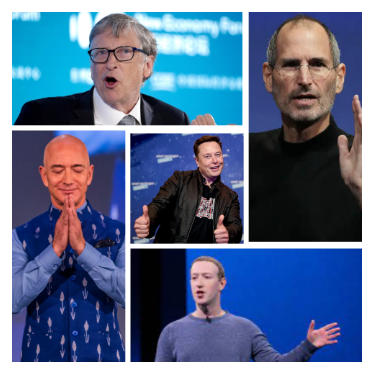 

    Проект позволяет обучить нейронную сеть и угадывать знаменитось по фотографии с accuracy 0.9978 на валидации. 
    Данная сеть умеет узнавать следующих людей:
        * Билл Гейтс
        * Илон Маск
        * Джефф Безос
        * Марк Цукирберг
        * Стив Джопс

In [1]:
# %matplotlib inline
# %load_ext tensorboard

import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
import numpy as np

from torch.nn import functional as F
# from torch.utils.data import DataLoader
import pytorch_lightning as pl

import warnings
warnings.filterwarnings("ignore")

print(pl.__version__)
print(torch.__version__)
print(torchvision.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(torch.cuda.is_available(), device)

2.4.0
2.4.0+cu118
0.19.0+cu118
True cuda


# Загрузка данных

In [2]:
DATASET_PATH= 'D:\\DataSet\\CV_project1_data'
BATCH_SIZE = 100

In [3]:
fpDataset_train= ImageFolder(os.path.join(DATASET_PATH, 'train'))
fpDataset_valid= ImageFolder(os.path.join(DATASET_PATH, 'valid'))

print(len(fpDataset_train), len(fpDataset_valid))

3000 914


## Визуализация датасета
Посмотрим на несколько примеров из тестовой и валидационной выборок

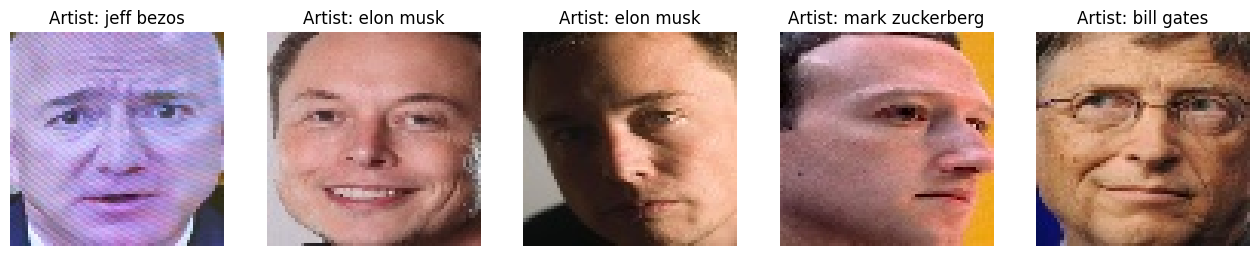

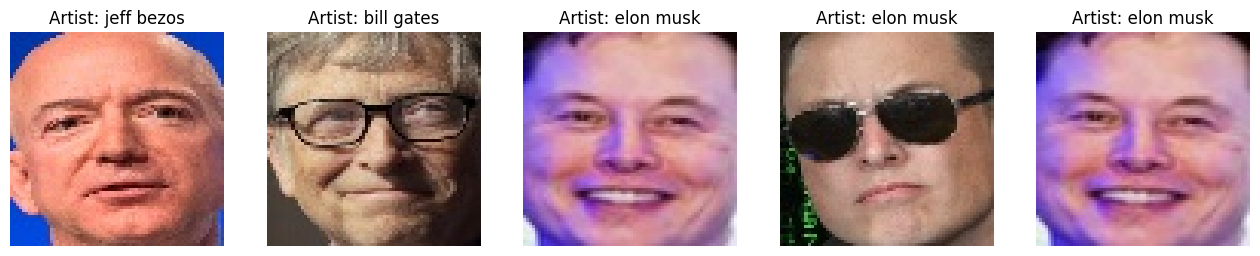

In [4]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples(fpDataset_train)
plot_samples(fpDataset_valid)

## Предобработка данных

    Для хорошей работы модели, необходимо привести данные к виду понятному и знакомому модели.
    Так же для того, чтобы модель меньше переобучалась, добавлю случайые аугментации для тестовых данных

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

fpDataset_train.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
fpDataset_valid.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

## Создаю загрузчики

In [6]:
train_loader = torch.utils.data.DataLoader(
    fpDataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), persistent_workers=True
)

valid_loader = torch.utils.data.DataLoader(
    fpDataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), persistent_workers=True
)

### Визуализация одного бача из загрузчики
Отобразим один бачь (трансформированных и нормализованных данных)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Классы объектов: tensor([4, 3, 0, 0, 3, 2, 4, 4, 3, 2, 1, 2, 3, 3, 3, 3, 2, 2, 2, 0, 1, 1, 3, 1,
        1, 3, 0, 3, 3, 3, 3, 4, 0, 1, 4, 1, 2, 1, 3, 0, 3, 4, 2, 3, 1, 0, 1, 3,
        0, 0, 3, 4, 2, 3, 1, 3, 1, 3, 0, 0, 4, 3, 0, 2, 1, 0, 1, 4, 4, 2, 3, 3,
        1, 2, 1, 2, 3, 3, 1, 4, 4, 2, 2, 3, 0, 2, 4, 3, 4, 3, 4, 4, 0, 1, 0, 1,
        2, 2, 4, 2])


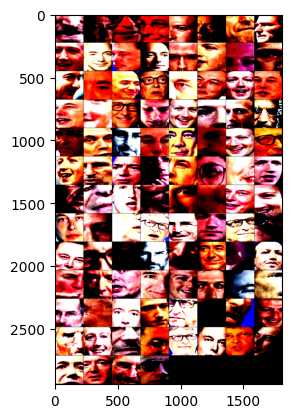

In [7]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

# classes = train_data.classes
# classes

# print([classes[i] for i in y_train])
print(f'Классы объектов: {y_train}')
plt.imshow(img)

# Обучение модели
    Для классификации знаменитостей я решил выбрать ReseNet34. т.к. эта сеть хорошо показала себя в задаче классификации и обучена на датасете ImageNet (должна уметь вычленять необходимые признаки из картинок).
    т.к. у нас не очень много данных, начну с обучения классифиатора и буду постепенно продвигаться с конца к сети к началу (дообучая слои), пока модель будет обучаться.

In [8]:
class famousPeopleModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.lr = 1e-2
        # используем предобученную модель ResNet-34
        self.net = torchvision.models.resnet34(pretrained=True)
        # замораживаем веса
        for parameter in self.net.parameters():
            # ...
            parameter.requires_grad = False
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = torch.nn.Linear(512, 5)


    # вызов модуля
    def forward(self, x):
        return self.net(x)

    # шаг обучения
    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        # нужно вернуть основное значение лосса (функции потерь)
        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch
        with torch.no_grad():
            output = self(images)
            loss = F.cross_entropy(output, target)
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    # используемые оптимизаторы
    def configure_optimizers(self):
        # return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-3)
        weight_decay = self.lr / 5
        # weight_decay = self.lr / 10
        # return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=weight_decay)
        return torch.optim.Adam(self.net.parameters(), lr=self.lr, weight_decay=weight_decay)

In [9]:
# Инициализируем модуль
famousPeople_model = famousPeopleModel()

famousPeople_model

famousPeopleModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [19]:
# Для начала обучу классификатор
famousPeople_model.lr = 1e-2
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Дальше понижаю шаг обучения и дообучаю с layer4
famousPeople_model.lr = 5e-3
for parameter in famousPeople_model.net.layer4.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Еще немного дообучить
famousPeople_model.lr = 1e-3
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# И еще немного
famousPeople_model.lr = 1e-4
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer3
famousPeople_model.lr = 1e-4
for parameter in famousPeople_model.net.layer3.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer2
famousPeople_model.lr = 1e-4
for parameter in famousPeople_model.net.layer2.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)
# Расширяю обучение на layer1
famousPeople_model.lr = 1e-5
for parameter in famousPeople_model.net.layer1.parameters():
    parameter.requires_grad = True
trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
trainer.fit(famousPeople_model, train_loader, valid_loader)

# famousPeople_model.lr = 1e-6
# trainer = pl.Trainer(devices=-1, max_epochs=10, enable_progress_bar=True)
# trainer.fit(famousPeople_model, train_loader, valid_loader)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
----------------------------------------
0 | net  | ResNet | 21.3 M | train
----------------------------------------
21.3 M    Trainable params
9.5 K     Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)
116       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 30/30 [00:11<00:00,  2.53it/s, v_num=92, loss/val=0.020, top1/val=0.995, top1/train=0.985] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 30/30 [00:13<00:00,  2.18it/s, v_num=92, loss/val=0.020, top1/val=0.995, top1/train=0.985]


## Визуализация процесса обучения

In [17]:
%load_ext tensorboard
# %tensorboard --logdir './lightning_logs'
%tensorboard --logdir='D:/From_Laptop/Документы/Python/SkillFactory_CV/PROJECT-1. Угадай знаменитость/lightning_logs' --port 5006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Итоговый результат
В конце 80 эпохи, модель перестала улучшать показатели на валидации и достагла стабильного Accuracy **0.9978**

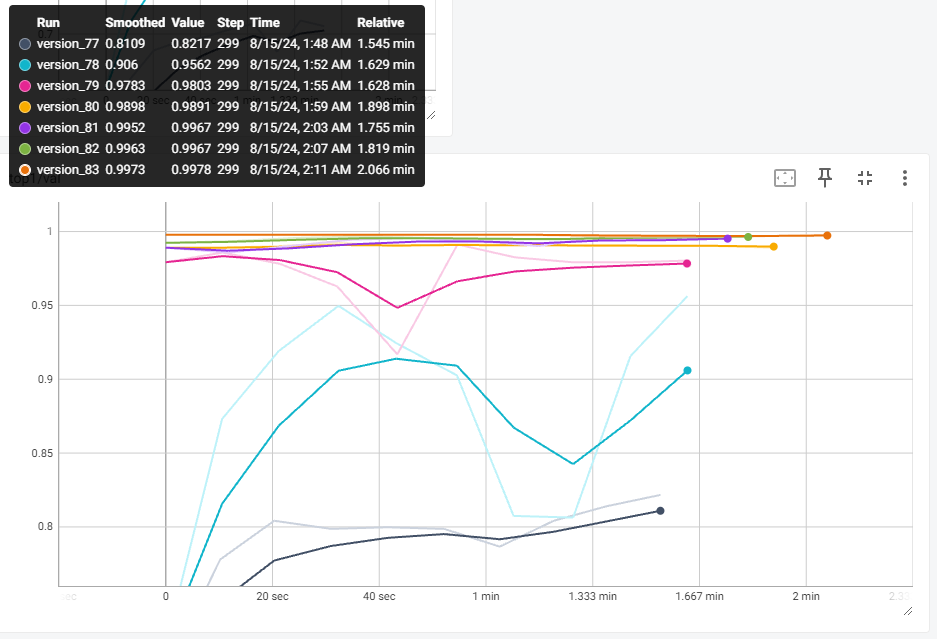

## Предсказания модели

In [172]:
def plot_samples_predict(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image.numpy().transpose((1,2,0)))
        axes[i].set_title("Artist: " + random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

plot_samples_predict(fpDataset_valid, 5)

### Предскажем класс на изображении не из выборки

tensor([[ 0.9395,  1.3751, -0.1178, -0.1472, -0.3551]])


'elon_musk'

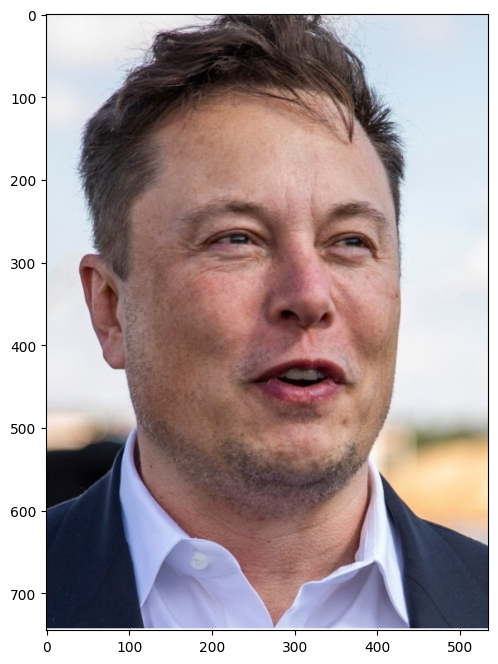

In [173]:
from PIL import Image

TEST_FOLDER = './test/Elon_Mask/'

image = Image.open(TEST_FOLDER + "04.jpg")

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(image)

tensor = fpDataset_valid.transform(image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = famousPeople_model(batch.to("cpu")).to("cpu")
print(output)

predicted = output.argmax().item()
fpDataset_valid.classes[predicted]

## Предсказываю для всех изображений по одному
Для каждого ихображения создается свой батч

7
tensor([[ 1.1629,  1.1434,  0.1661, -0.3923, -0.3126]])
tensor([[ 1.1611,  0.9414,  0.4098, -0.6589, -0.0537]])
tensor([[ 0.9366,  1.2085,  0.1625, -0.3706, -0.1083]])
tensor([[ 1.0926,  0.7748,  0.2507, -0.3167,  0.0102]])
tensor([[ 0.4940,  1.0474,  0.3615, -0.0227, -0.1849]])
tensor([[ 0.9506,  1.1895,  0.1422, -0.1888, -0.4712]])
tensor([[ 0.9395,  1.3751, -0.1178, -0.1472, -0.3551]])


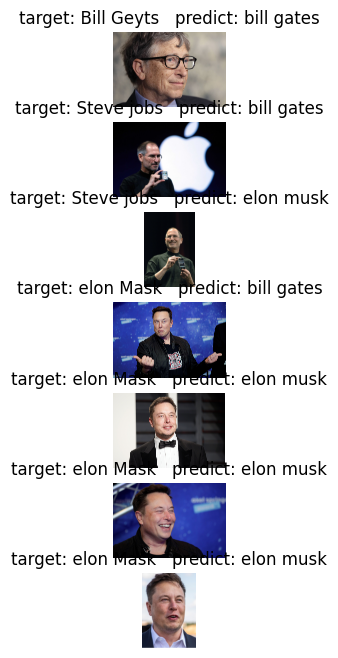

In [216]:
from PIL import Image

# TEST_FOLDER = './test/Elon_Mask/'
fpDataset_test= ImageFolder('./test')

print(len(fpDataset_test))
fig, axes = plt.subplots(len(fpDataset_test), 1, figsize=(16, 8))

for i, (image, target) in enumerate(fpDataset_test):

    # image = Image.open(TEST_FOLDER + "04.jpg")

    # fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    axes[i].imshow(image)
    axes[i].imshow(image)

    tensor = fpDataset_valid.transform(image)
    batch = torch.stack([tensor])
    with torch.no_grad():
        output = famousPeople_model(batch.to("cpu")).to("cpu")
    print(output)

    predicted = output.argmax().item()
    # fpDataset_valid.classes[predicted]

    target_label = fpDataset_test.classes[target]
    predict_label = fpDataset_valid.classes[predicted]

    axes[i].set_title(f"target: {target_label.replace('_', ' ')}   predict: {predict_label.replace('_', ' ')}")
    axes[i].axis('off')

## Предскажем для всех элементов TEST датасета

In [207]:
fpDataset_test= ImageFolder('./test')

print(len(fpDataset_test))

7


In [221]:
fpDataset_test.transform = fpDataset_valid.transform

test_loader = torch.utils.data.DataLoader(
    fpDataset_test, batch_size=len(fpDataset_test), shuffle=False, num_workers=os.cpu_count(), persistent_workers=True
)

X_test, y_test = next(iter(test_loader))

with torch.no_grad():
    output = famousPeople_model(X_test.to("cpu")).to("cpu")

# predicted = ...
predicted = output.argmax(axis=1)
# fpDataset_valid.classes[predicted]
for el in predicted:
    print(fpDataset_valid.classes[el])

bill_gates
mark_zuckerberg
elon_musk
mark_zuckerberg
steve_jobs
jeff_bezos
elon_musk


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].


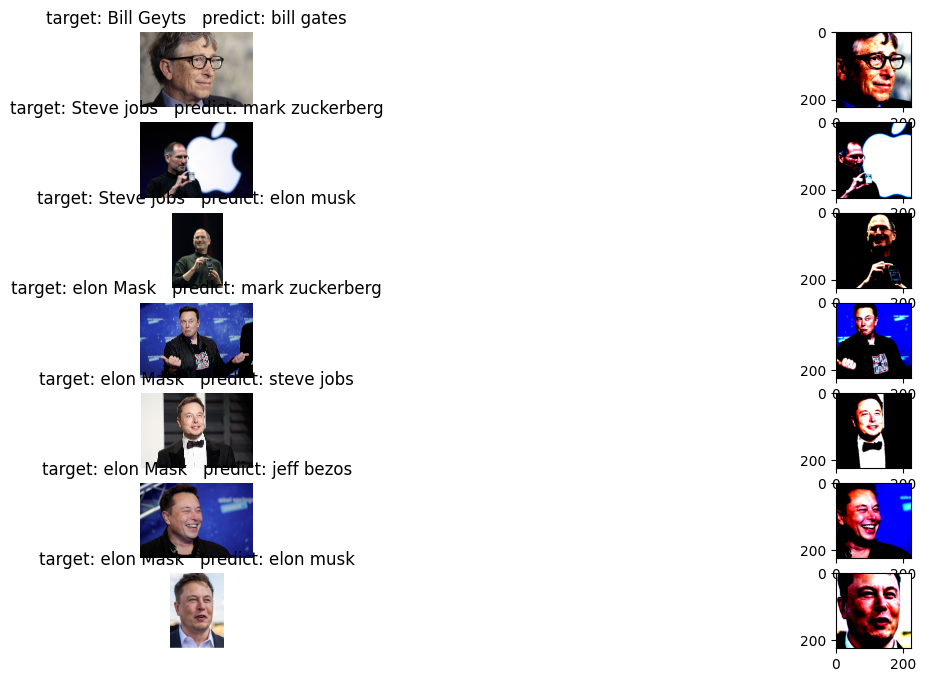

In [230]:
image_f = ImageFolder('./test')

fig, axes = plt.subplots(len(image_f), 2, figsize=(16, 8))

for i, (image, target) in enumerate(image_f):
    # random_image, random_class = random.choice(dataset)
    # random_image = image_f[i]
    target_label = image_f.classes[target]
    predict_label = fpDataset_valid.classes[predicted[i]]
    # print(image)
    axes[i][0].imshow(image)
    axes[i][0].set_title(f"target: {target_label.replace('_', ' ')}   predict: {predict_label.replace('_', ' ')}")
    axes[i][0].axis('off')
    # т.к. получаю плохие предсказания, решил дополнительно посмотерь на чеем предсказывает сеть
    axes[i][1].imshow(X_test[i].numpy().transpose((1,2,0)))


plt.show()   

## Результаты
В ходе проекта модель на основе resenet34 научилась угадывать предложенных снаменитостей по фотографии.